<a href="https://colab.research.google.com/github/AvantiShri/DeepCAC/blob/main/DeepCAC_port_to_python_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
!pip install pynrrd
!pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 8.4 MB/s eta 0:00:00


In [35]:
!git clone https://github.com/AvantiShri/DeepCAC.git

Cloning into 'DeepCAC'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 127 (delta 19), reused 7 (delta 7), pack-reused 87
Receiving objects: 100% (127/127), 374.43 MiB | 20.67 MiB/s, done.
Resolving deltas: 100% (44/44), done.
Updating files: 100% (55/55), done.


In [97]:
%cd /content/DeepCAC
!git pull

/content/DeepCAC
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (5/5), 1.32 KiB | 675.00 KiB/s, done.
From https://github.com/AvantiShri/DeepCAC
   45290a9..d55ea15  main       -> origin/main
Updating 45290a9..d55ea15
Fast-forward
 src/step1_heartloc/run_inference.py | 15 +++++++++++----
 1 file changed, 11 insertions(+), 4 deletions(-)


In [98]:
%cd /content/DeepCAC/src
!ls

/content/DeepCAC/src
config				 run_step2_heart_segmentation.py  step1_heartloc
README.md			 run_step3_cac_segmentation.py	  step2_heartseg
run_step1_heart_localization.py  run_step4_cac_scoring.py	  step3_cacseg


In [99]:
!python run_step1_heart_localization.py


--- STEP 1 - HEART LOCALIZATION ---

Data preprocessing:
Found 4 patients under "/content/DeepCAC/data/raw"
Processing patient 0187
Processing patient 0506
Processing patient 0987
Processing patient 0909

Data downsampling:
Found 4 patients under "/content/DeepCAC/data/step1_heartloc/curated" folder.
Processing patient 0987
Processing patient 0506
Processing patient 0909
Processing patient 0187
Saving results dictionary...

Input data preparation:
Loading input data from "/content/DeepCAC/data/step1_heartloc/resampled"
Found 4 patients under "/content/DeepCAC/data/step1_heartloc/resampled" folder.
Writing data file... 
Processing patient 0987
Processing patient 0506
Processing patient 0909
Processing patient 0187

Deep Learning model inference:
Input values are:
outdir path /content/DeepCAC/data/step1_heartloc/model_output indir path /content/DeepCAC/data/step1_heartloc/model_input model weights /content/DeepCAC/data/step1_heartloc/model_weights crop size 112 export png True down step

In [100]:
!ls

config				   run_step2_heart_segmentation.py  step2_heartseg
model_without_weights_loaded.hdf5  run_step3_cac_segmentation.py    step3_cacseg
README.md			   run_step4_cac_scoring.py
run_step1_heart_localization.py    step1_heartloc


In [106]:
import keras
from keras.saving import load_model

#from heartloc_model.py
def dice_coef(y_true, y_pred, smooth=1.):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

## ----------------------------------------
## ----------------------------------------

def dice_coef_loss(y_true, y_pred):
  return -dice_coef(y_true, y_pred)


model_without_weights = load_model(
    "model_without_weights_loaded.hdf5",
    custom_objects={"dice_coef_loss": dice_coef_loss,
                    "dice_coef": dice_coef})

In [109]:
model_without_weights.layers

In [113]:
#Go through and set the weights of each layer correctly
#model_without_weights.layers[1].get_weights()

In [121]:
import tables
import pickle
import os

#copied from https://github.com/AIM-Harvard/DeepCAC/blob/a1c2cd3b0ce082f047e042c1581b556ab08b0f77/src/step1_heartloc/run_inference.py#L68C3-L105C1
def get_input_data_to_model(dataDir, test_file, pkl_file, has_manual_seg, mgpu):
  testFileHdf5 = tables.open_file(os.path.join(dataDir, test_file), "r")
  pklData = pickle.load(open(os.path.join(dataDir, pkl_file), 'rb'))

  # Get data in one list for further processing
  testDataRaw = []
  num_test_imgs = len(testFileHdf5.root.ID)
  print(num_test_imgs)
  for i in range(num_test_imgs):
    patientID = (testFileHdf5.root.ID[i]).decode("utf-8") #python 2 to python 3 difference
    img = testFileHdf5.root.img[i]
    if has_manual_seg:
      msk = testFileHdf5.root.msk[i]
    else:  # Create empty dummy has_manual_seg with same size as the image
      sizeImg = len(img)
      msk = np.zeros((sizeImg, sizeImg, sizeImg), dtype=np.float64)
    print(pklData.keys())
    if not patientID in pklData.keys():
      print('Patient not found in pkl data', patientID)
      continue
    zDif = pklData[patientID][6][2]
    testDataRaw.append([patientID, img, msk, zDif])

  numData = len(testDataRaw)
  size = len(testDataRaw[0][1])
  imgsTrue = np.zeros((numData, size, size, size), dtype=np.float64)
  msksTrue = np.zeros((numData, size, size, size), dtype=np.float64)

  for i in range(0, len(testDataRaw) + 1, mgpu):
    imgTest = np.zeros((4, size, size, size), dtype=np.float64)

    for j in range(mgpu):
      # If the number of test images is not mod 4 == 0, just redo the last file severall times
      patientIndex = min(len(testDataRaw) - 1, i + j)
      patientID = testDataRaw[patientIndex][0]
      print('Processing patient', patientID)
      # Store data for score calculation
      imgsTrue[patientIndex, :, :, :] = testDataRaw[patientIndex][1]
      msksTrue[patientIndex, :, :, :] = testDataRaw[patientIndex][2]
      imgTest[j, :, :, :] = testDataRaw[patientIndex][1]

  return imgTest

input_data_to_model = get_input_data_to_model(
    dataDir="/content/DeepCAC/data/step1_heartloc/model_input", #model_input_dir_path
    test_file="step1_test_data.h5",
    pkl_file="step1_downsample_results.pkl",
    has_manual_seg=True,
    mgpu=1)


4
dict_keys(['0987', '0506', '0909', '0187'])
dict_keys(['0987', '0506', '0909', '0187'])
dict_keys(['0987', '0506', '0909', '0187'])
dict_keys(['0987', '0506', '0909', '0187'])
Processing patient 0987
Processing patient 0506
Processing patient 0909
Processing patient 0187
Processing patient 0187


In [123]:
input_data_to_model.shape

(4, 112, 112, 112)

In [ ]:
model_preds = model_without_weights.predict(input_data_to_model)

For visualizing input data:

In [8]:
import numpy as np
import nrrd
readdata, header = nrrd.read('img.nrrd')

In [9]:
%matplotlib inline

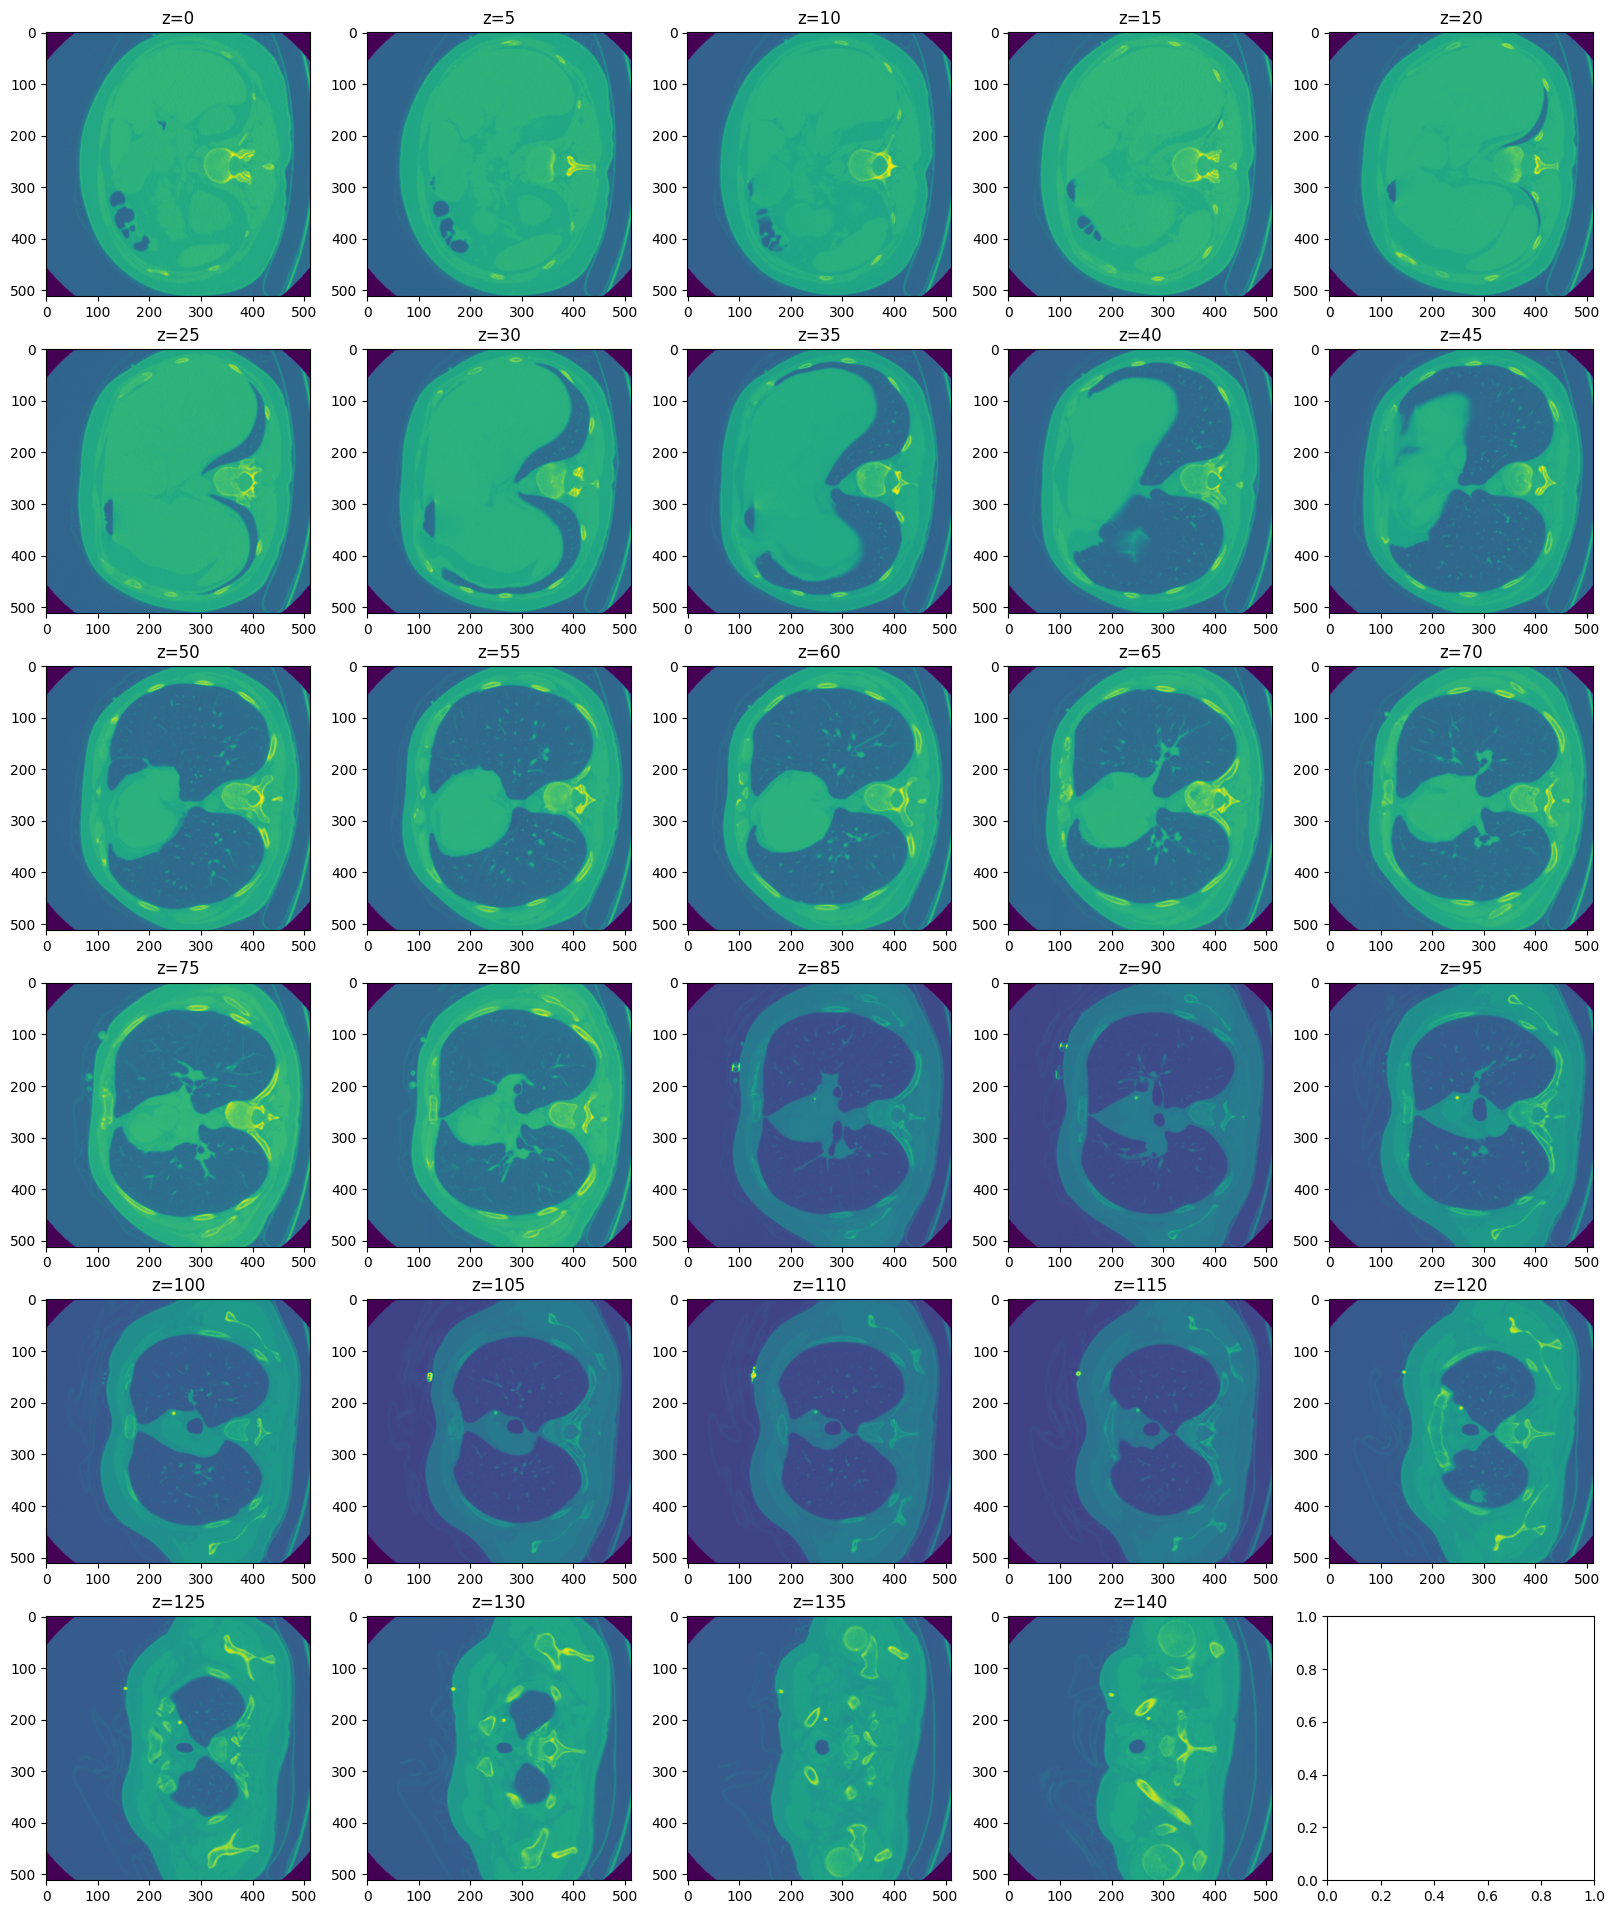

In [12]:
from matplotlib import pyplot as plt

def sliceplot_z(np_array, ncols, stepsize, figsizepercol=4):
    plotdimlen = np_array.shape[2]
    numplots = int(plotdimlen/stepsize)
    nrows=int(np.ceil(numplots/ncols))
    fig, ax = plt.subplots(nrows=nrows,
                           ncols=ncols,
                           figsize=(ncols*figsizepercol,
                                    nrows*figsizepercol))
    for plotidx,i in enumerate(range(0, plotdimlen, stepsize)):
        plt.sca(ax[int(plotidx/ncols), plotidx%ncols])
        plt.imshow(np_array[:,:,i])
        plt.title("z="+str(i))
    plt.show()

sliceplot_z(readdata, ncols=5, stepsize=5)

In [13]:
readdata.shape

(512, 512, 143)